In [1]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
import astropy.constants as C
from math import ceil
import reverse_indices_2d as ri
import astropy as aspy
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline as spline
import cmasher as cm
import copy

In [2]:
run ../scripts/rc_params.py

rcParams updated :)


## The Catalogs

In [3]:
#Create a dataframe of PHATTER sources
#First cut to the data is GST criteria for the IR filters

phatter = vaex.open('/Users/tatianasandford/Documents/Research/M33/M33_full_matched.hdf5')

phatter['full_index'] = np.arange(len(phatter))
raw_f110, raw_f160 = phatter.F110W_VEGA.evaluate(), phatter.F160W_VEGA.evaluate()

phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')

phatter = phatter[
        (phatter.F110W_SNR > 4) & (phatter.F110W_SHARP**2 < 0.15) & (phatter.F110W_CROWD < 2.25) & 
        (phatter.F160W_SNR > 4) & (phatter.F160W_SHARP**2 < 0.15) & 
        (phatter.F160W_CROWD < 2.25) & (phatter.F110W_VEGA == phatter.F110W_VEGA)
       ]

In [4]:
#Add index to PHATTER dataframe

###Add 110-160 color column to dataframe for convenience
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

In [5]:
# Set the aspect ratio for any ra/dec plot of M33

ra_max, ra_min = phatter.RA.max(), phatter.RA.min()
dec_max, dec_min = phatter.DEC.max(), phatter.DEC.min()
dec_m33 = phatter.DEC.mean()

m33_ar = (dec_max - dec_min) / ((ra_max - ra_min)*np.cos(np.pi/180.*dec_m33))

In [6]:
#Extract RA, and DEC  with GST cuts for easy plotting later
ra_gst, dec_gst = phatter.RA.evaluate(), phatter.DEC.evaluate()

In [7]:
print('Coordinate Span of PHATTER footprint')
print('RA (deg): {:.4f} - {:.4f}'.format(ra_min, ra_max))
print('DEC (deg): {:.4f} - {:.4f}'.format(dec_min, dec_max))

Coordinate Span of PHATTER footprint
RA (deg): 23.3422 - 23.6613
DEC (deg): 30.4894 - 30.8491


In [8]:
sage_all = fits.open('./sage_lmc_smc.fits')
sage_all.info()

Filename: ./sage_lmc_smc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      72   ()      
  1  II_305_archive    1 BinTableHDU    154   9094829R x 28C   [B, 19A, D, D, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, D, D, D, D]   
  2  II_305_catalog    1 BinTableHDU    149   8414394R x 28C   [D, D, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, D, D, D, D, A, 19A]   


In [9]:
sage1 = aspy.table.Table(sage_all[1].data)
sage2 = aspy.table.Table(sage_all[2].data)

In [10]:
len(sage1), len(sage2)

(9094829, 8414394)

In [11]:
sage2[:2]

RAJ2000,DEJ2000,Jmag,e_Jmag,q_Jmag,Hmag,e_Hmag,q_Hmag,__3_6_,e__3_6_,q__3_6_,__4_5_,e__4_5_,q__4_5_,__5_8_,e__5_8_,q__5_8_,__8_0_,e__8_0_,q__8_0_,SNJ,SNH,SN3_6,SN4_5,SN5_8,SN8_0,A,SSTISAGEMC
float64,float64,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float64,float64,float64,float64,str1,str19
36.532553,-75.584016,nan,nan,-9,nan,nan,-9,17.1,0.135,24576,nan,nan,8413184,nan,nan,-9,nan,nan,-9,nan,nan,8.020000457763672,nan,nan,nan,A,J022607.81-753502.4
36.534314,-75.586757,11.241,0.024,29360128,10.952,0.024,29360128,10.82,0.04,16384,10.864,0.034,16384,10.789,0.036,0,10.603,0.108,512,45.24,45.24,27.219999313354492,32.18000030517578,30.270000457763672,10.0600004196167,A,J022608.23-753512.3


In [12]:
lmc_only, = np.where((sage2['RAJ2000'] > 50) & (~np.isnan(sage2['Jmag'])) & (~np.isnan(sage2['Hmag'])))

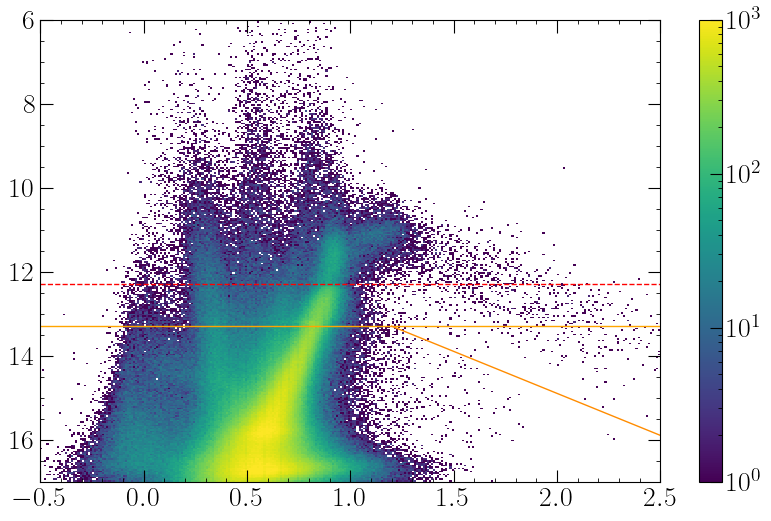

In [13]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,6)

cmap = cm.get_sub_cmap('viridis', 0.0, 1.0)
cmap.set_under('w')

plot = ax.hist2d(sage2['Jmag'][lmc_only] - sage2['Hmag'][lmc_only], sage2['Hmag'][lmc_only], 
          bins=300, range=[[-0.5,2.5], [6,17]],
          cmap=cmap, norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e3))
ax.invert_yaxis()

ax.hlines(12.3, -0.5, 2.5, color='red', linestyle='--', linewidth=1)
ax.hlines(13.3, -0.5, 2.5, color='orange', linestyle='-', linewidth=1)

def lmc_goldman_line(x):
    y = (2*x) + 10.9
    return y

lmc_goldx = np.linspace(1.2, 4, 1000)
lmc_goldy = lmc_goldman_line(lmc_goldx)

ax.plot(lmc_goldx, lmc_goldy, color='darkorange', linestyle='-', linewidth=1)

plt.colorbar(plot[3], ax=ax);

In [384]:
spitz_fits = fits.open('./spitzer_m33.fits')
spitz_fits.info()

Filename: ./spitzer_m33.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   ()      
  1  J_ApJS_219_42_psc    1 BinTableHDU    111   78841R x 20C   [D, D, E, E, E, E, E, E, A, E, E, E, A, E, E, E, A, E, E, 7A]   


In [385]:
names = ['ra', 'dec', 'mag36', 'e36', 'd36', 'mag45', 'e45', 'd45', 'blank1', 'mag58', 'e58', 'd58', 'blank2', 'mag80', 'e80', 'd80', 'blank3', 'mag24', 'e24', 'Gal']
spitz_all = aspy.table.Table(spitz_fits[1].data, names=names)
spitz_all.remove_columns(['blank1', 'blank2', 'blank3'])

In [386]:
spitz_all[:2]

ra,dec,mag36,e36,d36,mag45,e45,d45,mag58,e58,d58,mag80,e80,d80,mag24,e24,Gal
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7
23.40441,30.389219999999995,7.72,0.05,-0.69,7.75,0.03,-0.2,7.66,0.02,0.04,7.6,0.06,0.01,7.65,0.05,M33
23.662449999999996,30.844349999999995,7.86,0.03,-0.6,7.89,0.02,-0.15,7.74,0.01,0.02,7.65,0.11,0.01,7.69,0.01,M33


In [387]:
len(spitz_all)

78841

In [388]:
cut, = np.where((spitz_all['ra'] >= 23.342) & (spitz_all['ra'] <= 23.662) & (spitz_all['dec'] >= 30.489) & (spitz_all['dec'] <= 30.850))

In [389]:
spitz_ftprnt = spitz_all[cut]

In [390]:
#spitz_ftprnt.write('./spitzer_phatter_ftprnt.csv')

In [391]:
sg = ascii.read('./m33_spitzer_gaia_xmatch.csv')

In [488]:
sg[400:402]

separation,spitzer_phatter_ftprnt_oid,ra,dec,mag36,e36,d36,mag45,e45,d45,mag58,e58,d58,mag80,e80,d80,mag24,e24,gal,solution_id,designation,source_id,random_index,ref_epoch,ra_1,ra_error,dec_1,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,int64,str27,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,str13,float64,float64,float64,float64,str5,str5,int64,str5,str5,str5,str5,str5,str5,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,fl

In [585]:
sg_mw, = np.where(~((((sg['parallax'] + (17*1e-3)) / sg['parallax_error']) <= 5.0) & (((sg['pmra'] / sg['pmra_error'])**2 + (sg['pmdec'] / sg['pmdec_error'])**2) < 25.0)))

In [586]:
len(sg), len(sg_mw)

(8674, 684)

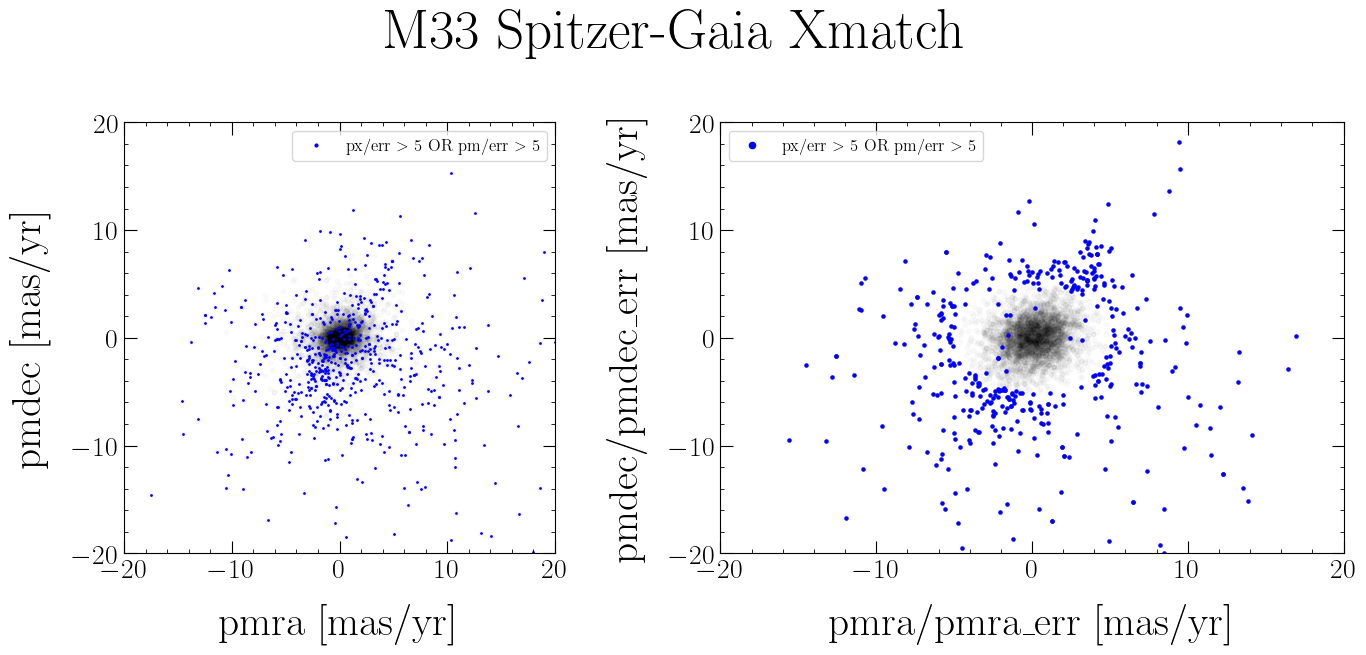

In [588]:
fig, (ax,ax2) = plt.subplots(1,2)
fig.set_size_inches(14,5)
fig.tight_layout()


ax.scatter(sg['pmra'], sg['pmdec'], s=10, c='black', alpha=0.02)
ax.scatter(sg['pmra'][sg_mw], sg['pmdec'][sg_mw], s=1, c='blue', label='px/err $>$ 5 OR pm/err $>$ 5')
ax.legend(fontsize='large')

ax.set_xlabel('pmra [mas/yr]')
ax.set_ylabel('pmdec [mas/yr]')

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

ax.set_aspect(1)

##############
##PLOT 2######
##############

ax2.scatter(sg['pmra']/sg['pmra_error'], sg['pmdec']/sg['pmdec_error'], s=10, c='black', alpha=0.02)

ax2.scatter(sg['pmra'][sg_mw]/sg['pmra_error'][sg_mw], sg['pmdec'][sg_mw]/sg['pmdec_error'][sg_mw], 
           s=5, c='blue', 
           label='px/err $>$ 5 OR pm/err $>$ 5')
ax2.legend(fontsize='large')

ax2.set_xlabel('pmra/pmra_err [mas/yr]')
ax2.set_ylabel('pmdec/pmdec_err [mas/yr]')

ax2.set_xlim(-20,20)
ax2.set_ylim(-20,20)

fig.text(0.5, 1.1, 'M33 Spitzer-Gaia Xmatch', fontsize=40, ha='center');

In [589]:
remove = np.unique(np.array(sg['spitzer_phatter_ftprnt_oid'][sg_mw]))
spitzer_i = np.arange(0, len(spitz_ftprnt), 1)
spitzer_j = np.delete(spitzer_i, remove)

In [590]:
spitz_pm_cut = spitz_ftprnt[spitzer_j]
spitz_other = spitz_ftprnt[sg_mw]
len(spitz_pm_cut), len(spitz_other)

(25256, 684)

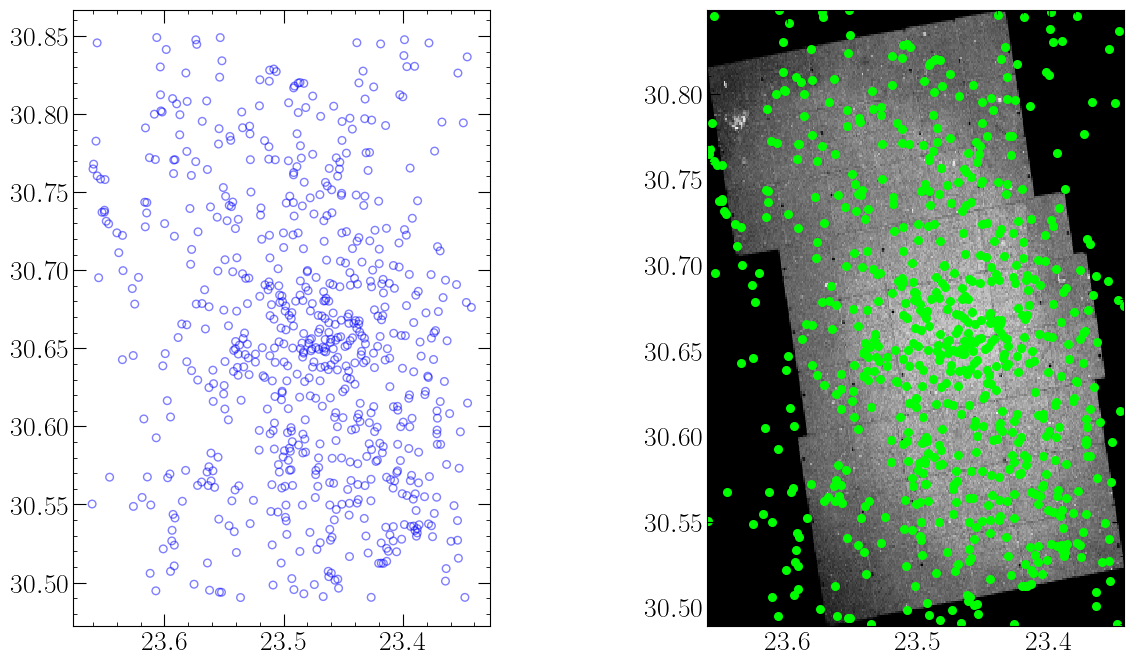

In [591]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15,8)

ax1.set_aspect(m33_ar)
ax2.set_aspect(m33_ar)
#ax1.scatter(spitz_pm_cut['ra'], spitz_pm_cut['dec'], c='black', s=5, alpha=0.1)
plot1 = ax1.scatter(spitz_other['ra'], spitz_other['dec'], 
                    edgecolor='blue', facecolor='none',
                    alpha=0.5,
                    s=30)#sg['pm'][foreground])
ax1.invert_xaxis();
ax2.hist2d(phatter.RA.evaluate(), phatter.DEC.evaluate(), bins=300, cmap='Greys_r')
ax2.scatter(spitz_other['ra'], spitz_other['dec'], c='lime', s=30);
ax2.invert_xaxis();

#plt.colorbar(plot1, ax=ax1, label='pmdec/pmdec_error');

## Data Reduction

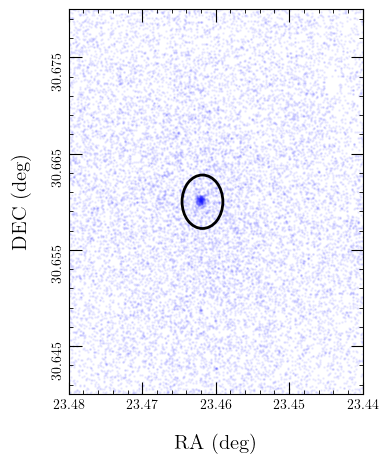

In [28]:
#Define a circle around the center of the galaxy where crowding has the most effect

fig, ax = plt.subplots(1)
fig.set_size_inches(5,5)

plt.rcParams["axes.axisbelow"] = False



qc, = np.where(phatter.F160W_VEGA.evaluate() <= 20)
plot = ax.scatter(ra_gst[qc], dec_gst[qc],
                 #bins=300,
                 #cmap=cmap,
                 #vmax=20
                  c='blue', s=1, alpha=0.05
                );
center_ra, center_dec = 23.4618, 30.66
ctr = patches.Circle((center_ra, center_dec), radius=10/3600, edgecolor='black', facecolor=(0,0,0,0), linewidth=2)
ax.add_patch(ctr)

#zoom in on center
ax.set_xlim(23.44,23.48)
ax.set_ylim(30.64,30.68)
ax.set_yticks([30.645, 30.655, 30.665, 30.675])
ax.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='y', labelrotation=90)

ax.set_xlabel('RA (deg)', fontsize=15)
ax.set_ylabel('DEC (deg)', fontsize=15)

ax.set_aspect(m33_ar)
ax.invert_xaxis()

plt.savefig('./images/ctr_cutout.png', bbox_inches='tight')

In [29]:
#remove the spitzer sources within the central circle
ctr_path = ctr.get_path()
ctr_transform = ctr.get_patch_transform()
c_path = ctr_transform.transform_path(ctr_path)

spitz_pts = np.stack((spitz_pm_cut['ra'], spitz_pm_cut['dec']), axis=1)
no_ctr, = np.where(~c_path.contains_points(spitz_pts))

spitzer = spitz_pm_cut[no_ctr]

In [30]:
#Add an index to more easily reference specific sources
spitzer['index'] = np.arange(0, len(spitzer), 1)

In [31]:
spitzer['mag36'].max()

19.53

In [32]:
280*u.Jy.to(u.mJy)

280000.0

In [33]:
#Spitzer 3.6 band flux convertsion from Reach et al, 2005
#Absolute Calibration of the Infrared Array...
#Gives the conversion to magnitude as m = 2.5log10(F_0/F_d)
#where F_d is the measured flux density and F_0 is the zero point
#The resulting zero‐magnitude flux densities are 280.9 ± 4.1, 179.7 ± 2.6, 115.0 ± 1.7, and 64.13 ± 0.94 Jy in the [3.6], [4.5], [5.8], and [8] μm
#seems to be 7.17 Jy for 24
#
#flux density - 280.9 +/- 4.1 for the 3.6 band

#F_d = 280.9(+-4.1)*10**(m/2.5)

def spitzer_36mag_to_fd(mag):
    #gives flux density
    fd = 280.9 * 10**(-mag / 2.5)
    return fd

def spitzer_45mag_to_fd(mag):
    #gives flux density
    fd = 179.7 * 10**(-mag / 2.5)
    return fd

def spitzer_58mag_to_fd(mag):
    #gives flux density
    fd = 115.0 * 10**(-mag / 2.5)
    return fd

def spitzer_80mag_to_fd(mag):
    #gives flux density
    fd = 64.13 * 10**(-mag / 2.5)
    return fd

def spitzer_24mag_to_fd(mag):
    #gives flux density
    fd = 7.17 * 10**(-mag / 2.5)
    return fd

# Color Conversion

In [34]:
#import the SAGE catalog - cut at 4 < 3.6mag < 11 and
#matched to gaia using their database xmatch capability
sage = vaex.open('./xmatch_sage_gaia.csv')

In [35]:
sage.head(2)

#,separation,sage_oid,c,sstisagema,raj2000,dej2000,jmag,e_jmag,q_jmag,hmag,e_hmag,q_hmag,col__3_6_,e__3_6_,q__3_6_,col__4_5_,e__4_5_,q__4_5_,col__5_8_,e__5_8_,q__5_8_,col__8_0_,e__8_0_,q__8_0_,snj,snh,sn3_6,sn4_5,sn5_8,sn8_0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
<i style='opacity: 0.6'>0</i>,0.000114445,1,1,J022608.23-753512.3,36.5343,-75.5868,11.241,0.024,2.93601e+07,10.952,0.024,2.93601e+07,10.82,0.04,16384,10.864,0.034,16384,10.789,0.036,0,10.603,0.108,512,45.24,45.24,27.22,32.18,30.27,10.06,1.63615e+18,Gaia DR3 4634185256147360384,4.63419e+18,7.89517e+08,2016,36.5348,0.0108566,-75.5867,0.0101583,1.84783,0.0118416,156.045,40.0127,33.8554,0.0120819,21.3266,0.0128596,0.00107817,0.419889,-0.0801707,-0.113675,0.0392334,-0.0279451,0.0107593,0.0990436,-0.220063,-0.0911263,347,347,345,2,3.81854,749.762,0.0839638,10.3538,31,True,1.5553,nan,nan,nan,nan,nan,nan,nan,40,26,0.0183404,46,17,0,0.0253767,68.059,0,0,1.14893,nan,nan,nan,nan,nan,nan,nan,nan,False,390,239913,47.4212,5059.18,12.2372,44,129190,62.6142,2063.27,12.5605,44,158518,56.2719,2817,11.7477,1.19922,0,1,0,0,0,0.81277,0.323236,0.489533,5.78594,0.713328,1,22,2,19,30.8924,-0.143329,0.375279,974.724,12.2899,5750,4,0.25,222,13.1103,10.4294,15,11.5786,0.0155482,20,31.1725,NOT_AVAILABLE,295.42,-40.1295,308.738,-71.3604,False

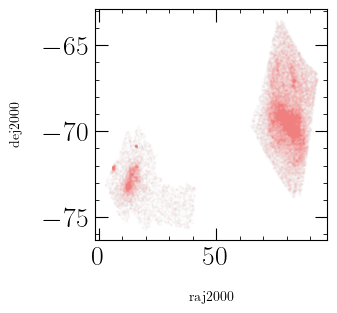

In [617]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,3)
ax.set_xlabel('raj2000', fontsize=10)
ax.set_ylabel('dej2000', fontsize=10)
ax.scatter(sage.raj2000.evaluate(), sage.dej2000.evaluate(), s=1, alpha=0.02);

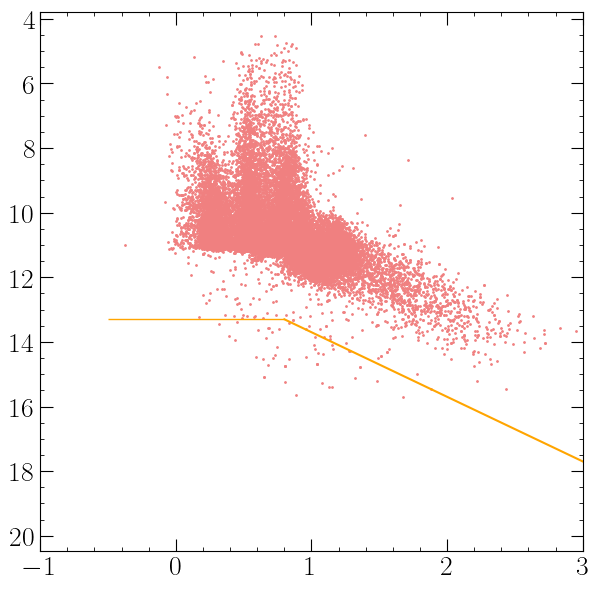

In [620]:
fig, ax = plt.subplots(1)

ax.scatter(sage.jmag.evaluate() - sage.hmag.evaluate(), sage.hmag.evaluate(), 
          s=1);

ax.hlines(13.3, -0.5, 0.8, color='orange', linestyle='-', linewidth=1)

def lmc_goldman_line(x):
    y = (2*x) + 11.7
    return y

lmc_goldx = np.linspace(0.8, 4, 1000)
lmc_goldy = lmc_goldman_line(lmc_goldx)
ax.plot(lmc_goldx, lmc_goldy, color='orange')

ax.set_xlim(-1,3)
ax.invert_yaxis();

In [836]:
#select sources in LMC only, filter out rows with nan for necessary data,
#with px/px_err <= 5 per Gaia collab 2021 - Structure and properties of the Magellanic Clouds
#with mag cut similar to Goldman paper, corrected for LMC TRGB
#13.3, y = (2*x) + 10.9 cut at 1.2
sage.select('(raj2000 > 50) &'
            '(jmag == jmag) & (hmag == hmag) & (col__3_6_ == col__3_6_) & '
            '(phot_g_mean_mag == phot_g_mean_mag) & (bp_rp == bp_rp) & '
            '(pm == pm) & (parallax_over_error <= 5) & '
            '(((jmag - hmag <= 0.8) & (hmag < 13.3)) | ((jmag - hmag > 0.8) & (hmag <= 2*(jmag - hmag) + 11.7)))',
            name='clean')

In [808]:
sage_pmra = sage.pmra.evaluate(selection='clean')
pmra_error = sage.pmra_error.evaluate(selection='clean')
sage_pmdec = sage.pmdec.evaluate(selection='clean')
pmdec_error = sage.pmdec_error.evaluate(selection='clean')
pm = sage.pm.evaluate(selection='clean')

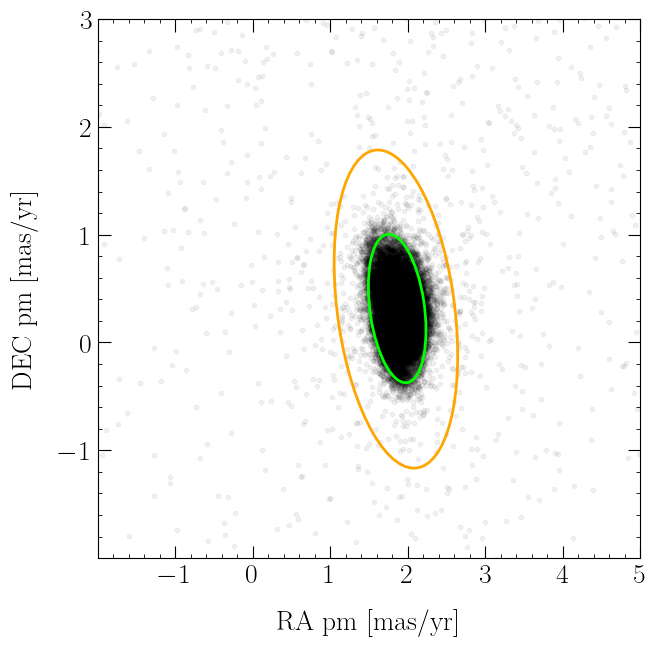

In [809]:
fig, ax = plt.subplots(1)
fig.set_size_inches(7,7)

ax.scatter(sage_pmra, sage_pmdec,
           s=10, 
           color='black', 
           alpha=0.05
          )

ax.set_xlim(-2,5)
ax.set_ylim(-2,3)
ax.set_xticks([ -1, 0, 1, 2, 3, 4, 5])
ax.set_yticks([-1, 0, 1, 2, 3])

ax.set_xlabel('RA pm [mas/yr]', fontsize=20)
ax.set_ylabel('DEC pm [mas/yr]', fontsize=20)

full_patch = mpl.patches.Ellipse((1.85, 0.31), width=1.5, height=3, angle=12, 
                                 edgecolor='orange', facecolor='none', 
                                 linewidth=2)

full_path = full_patch.get_path()
full_transform = full_patch.get_patch_transform()
lmc_full_path = full_transform.transform_path(full_path)
sage_ra, sage_dec = sage.pmra.evaluate(selection='clean'), sage.pmdec.evaluate(selection='clean')
lmc_points = np.stack([sage_ra, sage_dec], axis=1)
lmc_full, = np.where(lmc_full_path.contains_points(lmc_points))
medx, medy = np.median(sage_ra[lmc_full]), np.median(sage_dec[lmc_full])


pm_patch = mpl.patches.Ellipse((medx, medy), width=0.7, height=1.4, angle=12, 
                              edgecolor='lime', facecolor='none', 
                              linewidth=2)

ax.add_patch(pm_patch);
ax.add_patch(full_patch);

plt.savefig('./images/lmc_pm_plot.png', bbox_inches='tight')

In [810]:
pm_path = pm_patch.get_path()
pm_transform = pm_patch.get_patch_transform()
lmc_pm_path = pm_transform.transform_path(pm_path)
lmc_pms, = np.where(lmc_pm_path.contains_points(lmc_points))

In [811]:
jmag = sage.jmag.evaluate(selection='clean')[lmc_pms]
hmag = sage.hmag.evaluate(selection='clean')[lmc_pms] 
_36mag = sage.col__3_6_.evaluate(selection='clean')[lmc_pms]
gmag = sage.phot_g_mean_mag.evaluate(selection='clean')[lmc_pms] 
bprp = sage.bp_rp.evaluate(selection='clean')[lmc_pms]
jh = jmag - hmag
h36 = hmag - _36mag

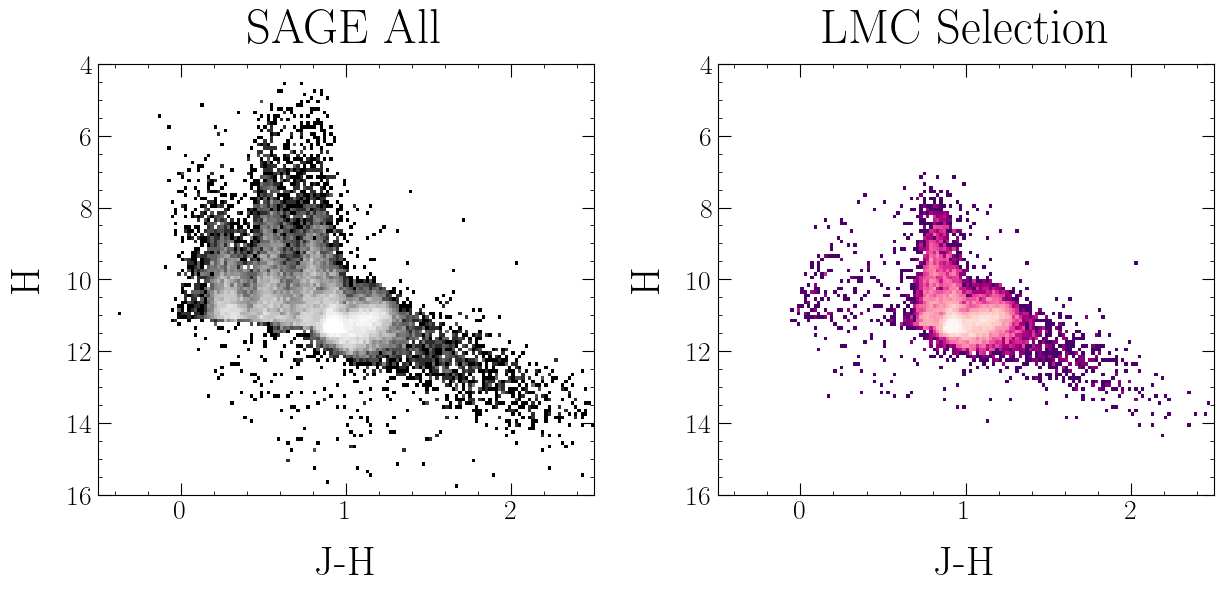

In [812]:
fig, (ax, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.tight_layout(w_pad=5)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [150, 120]
            
cmap1 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap1.set_under('w')

ax.hist2d(sage.jmag.evaluate() - sage.hmag.evaluate(), sage.hmag.evaluate(),
          bins=cmd_bins, range=cmd_range, 
          norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e2), cmap=cmap1)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(4,16)
ax.invert_yaxis()
ax.set_title('SAGE All')
ax.set_xlabel('J-H')
ax.set_ylabel('H')

cmap2 = copy.copy(mpl.cm.get_cmap('RdPu_r'))
cmap2.set_under('w')
ax2.hist2d(jh, hmag,  
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e2),
           bins=cmd_bins, range=cmd_range)


ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(4,16)
ax2.invert_yaxis()
ax2.set_title('LMC Selection')
ax2.set_xlabel('J-H')
ax2.set_ylabel('H');

plt.savefig('./images/lmc_cmds.png', bbox_inches='tight')

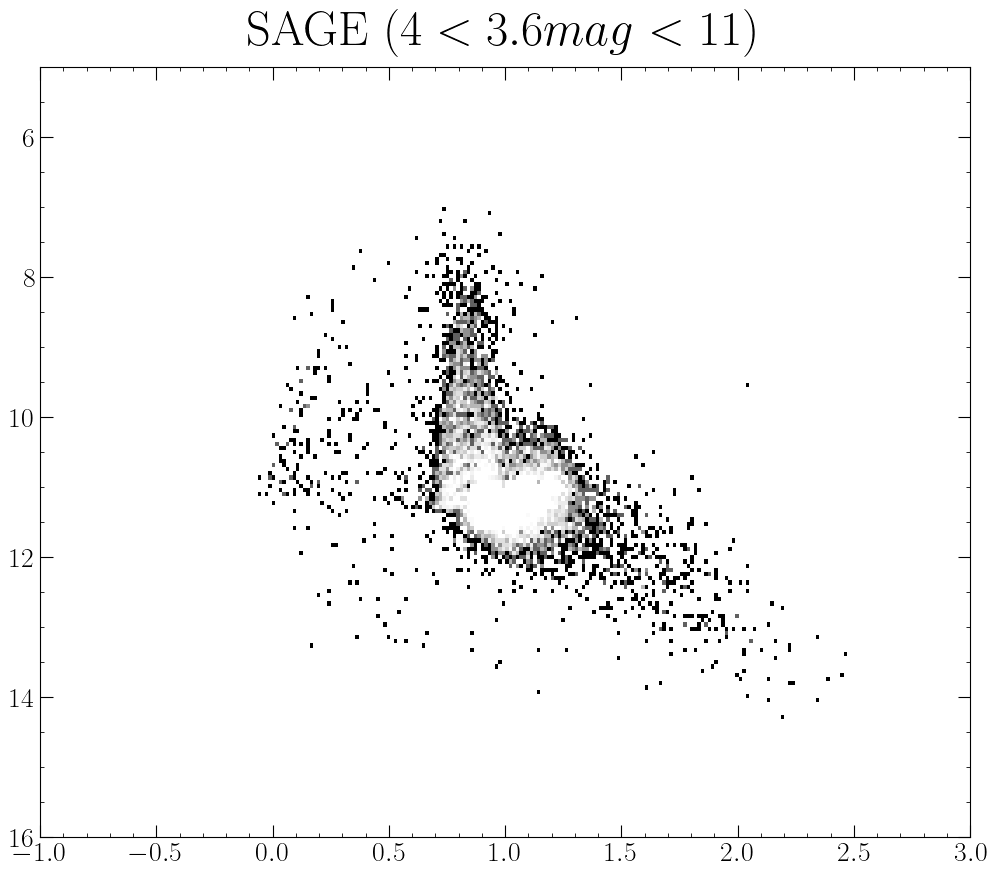

In [813]:
plt.clf()

from matplotlib.widgets import LassoSelector
%matplotlib inline

path_pts = []
def on_select(x):
    path_pts.append(x)
    

line_props={'color':'deeppink', 
            'linewidth':2
           }
    
fig, ax = plt.subplots(1)
fig.set_size_inches(12,10)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [200,200]
cmap2 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap2.set_under('w')
ax.hist2d(jh, hmag, 
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=10), 
           bins=cmd_bins, range=cmd_range)#c='blue', s=5, label='$4 < 3.6mag < 11$', alpha=0.2);

ax.set_xlim(-1,3)
ax.set_ylim(5,16)
ax.invert_yaxis()
ax.set_title('SAGE ($4 < 3.6mag < 11$)');

#patch1 = mpl.patches.PathPatch(Path(path_pts1), edgecolor='deeppink', facecolor='none')
#patch2 = mpl.patches.PathPatch(Path(path_pts2), edgecolor='deeppink', facecolor='none')
#patch3 = mpl.patches.PathPatch(Path(path_pts3), edgecolor='deeppink', facecolor='none')
#patch4 = mpl.patches.PathPatch(Path(path_pts4), edgecolor='deeppink', facecolor='none')
#patch5 = mpl.patches.PathPatch(Path(path_pts5), edgecolor='deeppink', facecolor='none')
#patch6 = mpl.patches.PathPatch(Path(path_pts6), edgecolor='deeppink', facecolor='none')
#patch7 = mpl.patches.PathPatch(Path(path_pts7), edgecolor='deeppink', facecolor='none')
#patch8 = mpl.patches.PathPatch(Path(path_pts8), edgecolor='deeppink', facecolor='none')
#patch9 = mpl.patches.PathPatch(Path(path_pts9), edgecolor='deeppink', facecolor='none')

#ptchs = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]

#for p in ptchs:
#    ax.add_patch(p);

lasso = LassoSelector(ax=ax, onselect=on_select, props=line_props, button=1);

In [814]:
np.shape(path_pts)

(0,)

In [815]:
#path_pts1 = np.reshape(path_pts, (389,2))

In [816]:
#path_pts2 = np.reshape(path_pts, (406,2))

In [817]:
#path_pts3 = np.reshape(path_pts, (383,2))

In [818]:
#path_pts4 = np.reshape(path_pts, (213,2))

In [819]:
#path_pts5 = np.reshape(path_pts, (484,2))

In [820]:
#path_pts6 = np.reshape(path_pts, (479,2))

In [821]:
#path_pts7 = np.reshape(path_pts, (548,2))

In [822]:
#path_pts8 = np.reshape(path_pts, (560,2))

In [823]:
#path_dict = {'p1': path_pts1, 
#             'p2': path_pts2, 
#             'p3': path_pts3, 
#             'p4': path_pts4, 
#             'p5': path_pts5, 
#             'p6': path_pts6,
#             'p7': path_pts7,
#             'p8': path_pts8
#            }

In [824]:
import pickle

#with open('path_dict.pickle', 'wb') as f:
#    # Pickle the dictionary using the highest protocol available.
#    pickle.dump(path_dict, f, pickle.HIGHEST_PROTOCOL)

with open('path_dict.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    path_dict = pickle.load(f)

In [825]:
patch1 = mpl.patches.PathPatch(Path(path_dict['p1']), edgecolor='deeppink', facecolor='none')
patch2 = mpl.patches.PathPatch(Path(path_dict['p2']), edgecolor='deeppink', facecolor='none')
patch3 = mpl.patches.PathPatch(Path(path_dict['p3']), edgecolor='deeppink', facecolor='none')
patch4 = mpl.patches.PathPatch(Path(path_dict['p4']), edgecolor='deeppink', facecolor='none')
patch5 = mpl.patches.PathPatch(Path(path_dict['p5']), edgecolor='deeppink', facecolor='none')
patch6 = mpl.patches.PathPatch(Path(path_dict['p6']), edgecolor='deeppink', facecolor='none')
patch7 = mpl.patches.PathPatch(Path(path_dict['p7']), edgecolor='deeppink', facecolor='none')
patch8 = mpl.patches.PathPatch(Path(path_dict['p8']), edgecolor='deeppink', facecolor='none')

In [826]:
ptchs = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]

<Figure size 700x700 with 0 Axes>

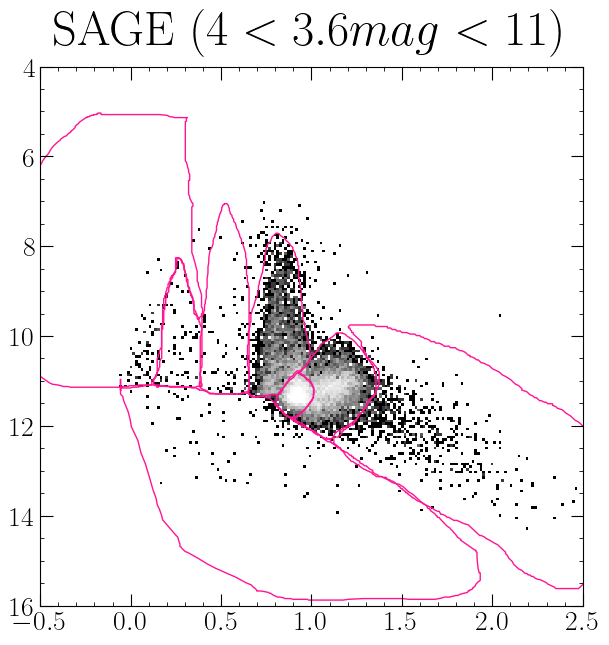

In [827]:
plt.clf()
fig, ax = plt.subplots(1)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [200,200]
cmap2 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap2.set_under('w')
ax.hist2d(jh, hmag, 
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=50), 
           bins=cmd_bins, range=cmd_range)#c='blue', s=5, label='$4 < 3.6mag < 11$', alpha=0.2);

#ax.set_xlim(0, 2.5)
#ax.set_ylim(6,15)
ax.invert_yaxis()
ax.set_title('SAGE ($4 < 3.6mag < 11$)');

for p in ptchs:
    ax.add_patch(p);

In [828]:
pts_jh = np.stack((jh, hmag), axis=1)
pts_jh

array([[ 0.90000057, 11.45699978],
       [ 0.92700005, 11.42000008],
       [ 1.1449995 , 11.58600044],
       ...,
       [ 1.188     , 11.347     ],
       [ 0.922     , 11.412     ],
       [ 2.196     , 12.713     ]])

In [829]:
grp1, = np.where(Path(path_dict['p1']).contains_points(pts_jh))
grp2, = np.where(Path(path_dict['p2']).contains_points(pts_jh))
grp3, = np.where(Path(path_dict['p3']).contains_points(pts_jh))
grp4, = np.where(Path(path_dict['p4']).contains_points(pts_jh))
grp5, = np.where(Path(path_dict['p5']).contains_points(pts_jh))
grp6, = np.where(Path(path_dict['p6']).contains_points(pts_jh))
grp7, = np.where(Path(path_dict['p7']).contains_points(pts_jh))
grp8, = np.where(Path(path_dict['p8']).contains_points(pts_jh))

grps = [grp1, grp2, grp3, grp4, grp5, grp6, grp7, grp8]

In [830]:
vals = np.full_like(jh, 0)
cols = np.full(np.shape(jh), 'aaaaaaaaaaaaaaaa')
colors = ['grey', 'orangered', 'deepskyblue','darkorange', 'blueviolet', 'gold', 'magenta', 'limegreen', 'deeppink']
for i in range(8):
    vals[grps[i]] = i + 1
    cols[grps[i]] = colors[i]

In [831]:
no_col, = np.where(cols == 'aaaaaaaaaaaaaaaa')
cols[no_col] = 'none'

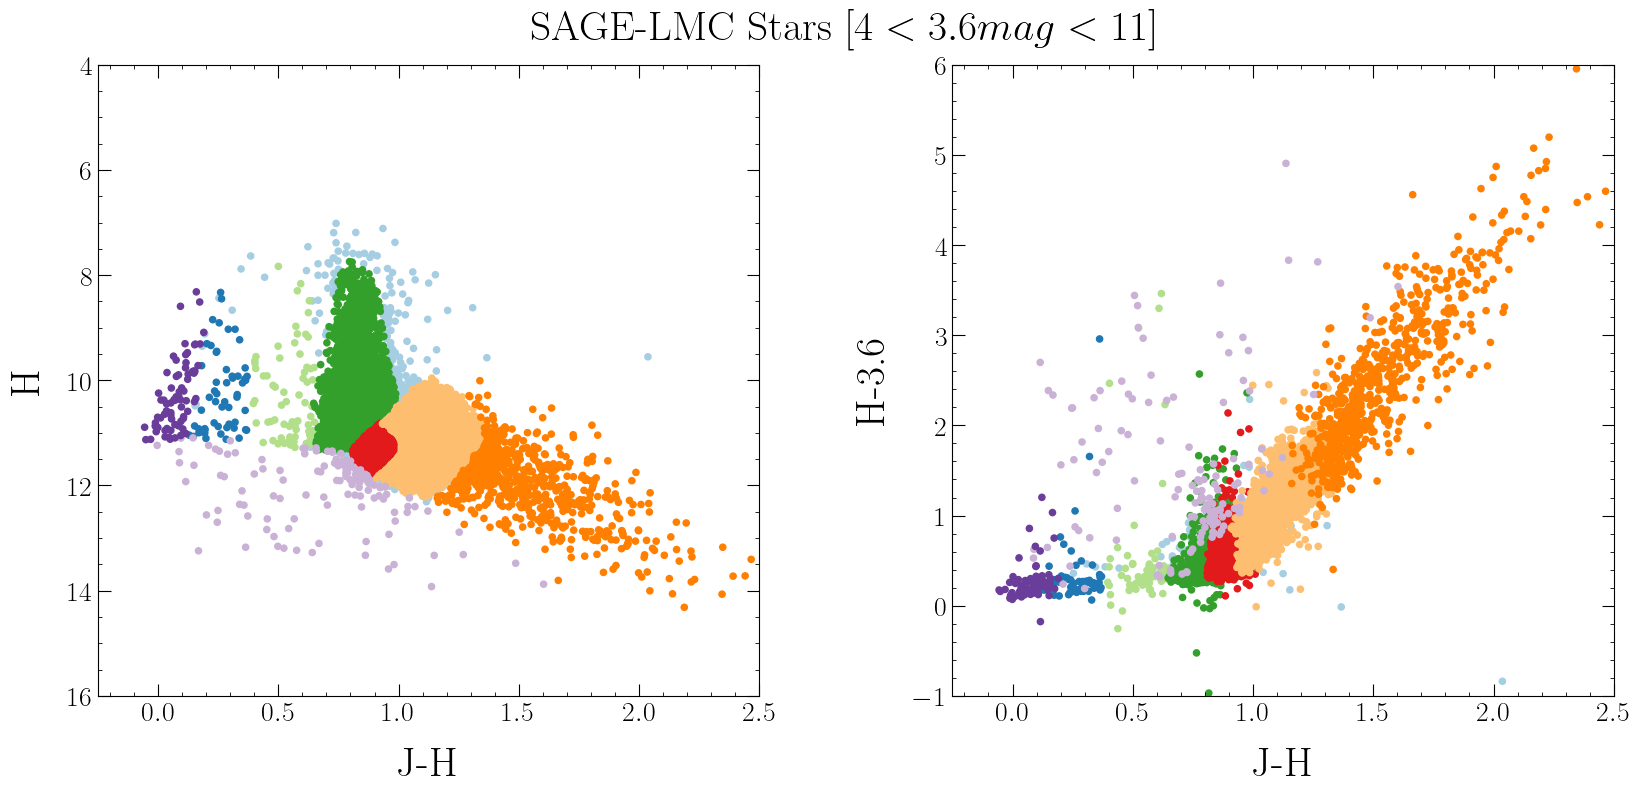

In [832]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,7)
fig.tight_layout(w_pad=10)

cmap = cm.get_sub_cmap('Paired', 0.0, 0.8)

#ax1.set_aspect(1/3)
ss = np.argsort(vals)
plot = ax1.scatter(jh[ss], hmag[ss], c=vals[ss], cmap=cmap, s=20)
ax1.set_xlabel('J-H')
ax1.set_ylabel('H')
ax1.set_xlim(-0.25, 2.5)
ax1.set_ylim(4,16)
ax1.invert_yaxis()


#ax2.set_aspect(2/3)
ax2.scatter(jh[ss], h36[ss], c=vals[ss], cmap=cmap, s=20)
ax2.set_xlim(-0.25,2.5)
ax2.set_ylim(-1,6)
ax2.set_xlabel('J-H')
ax2.set_ylabel('H-3.6');

#cax = fig.add_axes([1.0, 0.0, 0.05, 0.9])
#plt.colorbar(plot, cax=cax);
fig.text(0.5, 1.0 ,'SAGE-LMC Stars [$4 < 3.6mag < 11$]', fontsize=30, ha='center');

In [833]:
scatter, = np.where(vals != 7)
sct, = np.where(vals == 7)

In [834]:
bins = 52

lmc_colcol = np.histogram2d(jh[scatter], h36[scatter], bins=[bins*2, bins], range=[[-0.1, 2.5], [-0.5, 5.5]])

#list of median, mean, & std of hw1 values of a given slice
running_median = []
running_mean = []
running_std = []
#index values that have a usable mean
nz = []
#how many data points contribute to each median
wts = []
for i in range(bins*2):
    #finds the hw1 values for a given one-bin-width-slice of jh
    window = h36[scatter][np.where((jh[scatter] >= lmc_hist[1][i]) 
                            & (jh[scatter] < lmc_hist[1][i+1]))]
    ws = window.size
    if ws > 2:
        median = np.median(window)
        mean = np.mean(window)
        std = np.std(window)
        
        running_median.append(median)
        running_mean.append(mean)
        running_std.append(std)
        nz.append(i)
        wts.append(ws)

running_median = np.array(running_median)
running_mean = np.array(running_mean)
running_std = np.array(running_std)
wts = np.array(wts)

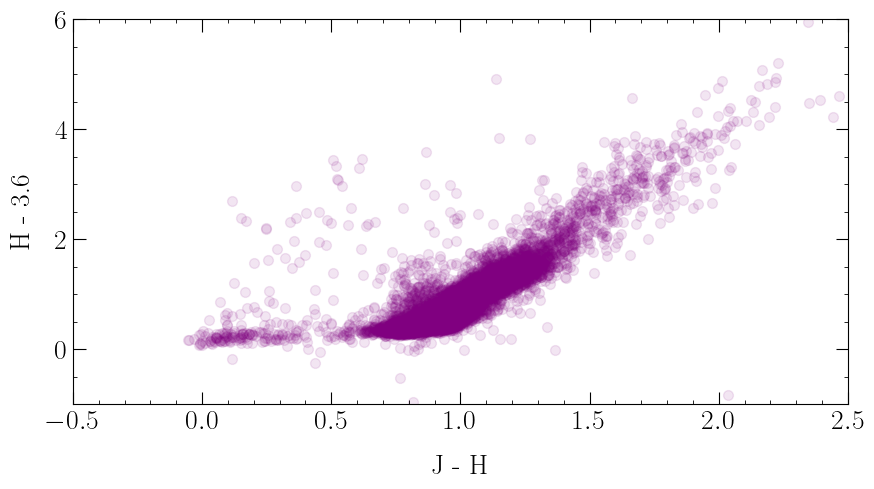

In [835]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,5)

ax.scatter(jh, h36, c='purple', marker='o', s=50, alpha=0.1)

ax.set_xlim(-0.25, 2.5)
ax.set_ylim(-0.5,5.5)

ax.set_xlabel('J - H', fontsize=20)
ax.set_ylabel('H - 3.6', fontsize=20)

ax.set_xlim(-0.5,2.5)
ax.set_ylim(-1,6);

ax.set_xlabel('J - H', fontsize=20)
ax.set_ylabel('H - 3.6', fontsize=20)


#fig.text(0.075, 0.5, 'H-W1', rotation='vertical', verticalalignment='center', fontsize=30);
#fig.text(0.5, 0.025, 'J-H', horizontalalignment='center', fontsize=30);

#plt.colorbar(lmc_colcol[3], ax=ax);

plt.savefig('./images/lmc_col_locus.png', bbox_inches='tight')

In [837]:
#define x data for spline fits
xs = lmc_colcol[1][:-1][nz]
line1, = np.where(xs < 0.7)
line2, = np.where(xs > 0.7)

#run spline fits
#sqr_spline = spline(xs[good], running_median[good], k=2)
#cube_spline = spline(xs[good], running_median[good], k=3)
#larger s = more smoothing

#fit1 = spline(xs[line1], running_median[line1], k=1)
#fit2 = spline(xs[line2], running_median[line2], k=1)

fit1 = stats.linregress((xs[line1], running_median[line1]))
fit2 = stats.linregress((xs[line2], running_median[line1]))

In [842]:
fit1.slope, fit1.intercept, fit1.stderr

(0.2656116184637846, 0.19754339128212783, 0.042852865373556266)

In [770]:
xx = np.linspace(-0.5,2.5,1000)

In [771]:
running_std.min()

0.025491959516678552

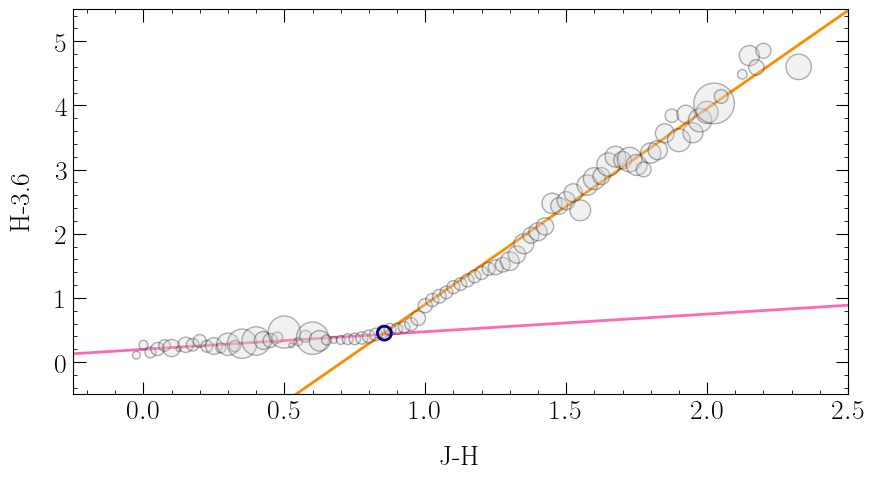

In [772]:
fig, ax2 = plt.subplots(1)
fig.set_size_inches(10,5)


ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-0.5,5.5)
ax2.set_xlabel('J-H', fontsize=20)
ax2.set_ylabel('H-3.6', fontsize=20)


ax2.plot(xx, fit1.__call__(xx), linewidth=2, linestyle='-', c='hotpink')
ax2.plot(xx, fit2(xx), linewidth=2, linestyle='-', c='darkorange')
ax2.scatter(xs, running_median,  
             marker='o',
             edgecolor='black', facecolor='lightgrey', 
             alpha=0.3, 
             s=running_std*500, 
             linewidth=1, label='Medians', 
             zorder=10
            );

x_intercept = 0.855
ax2.scatter(x_intercept, 0.45, edgecolor='darkblue', facecolor='none', lw=2, s=100, zorder=10)

plt.savefig('./images/col_loc_fits.png', bbox_inches='tight')

In [75]:
mosaic = [['JH panel', 'JH panel', 'JH panel', '.'],
          ['main plot', 'main plot', 'main plot', 'H36 panel'],
          ['main plot', 'main plot', 'main plot', 'H36 panel'],
          ['main plot', 'main plot', 'main plot',  'H36 panel'],
          ['sigma panel', 'sigma panel', 'sigma panel',  '.']
    
]

In [76]:
zrs, = np.where((jh == 0) & (h36 == 0))

In [77]:
jh_xs = np.linspace(-0.5, 3.0, len(jh))
h36_xs = np.linspace(-1, 6, len(jh))

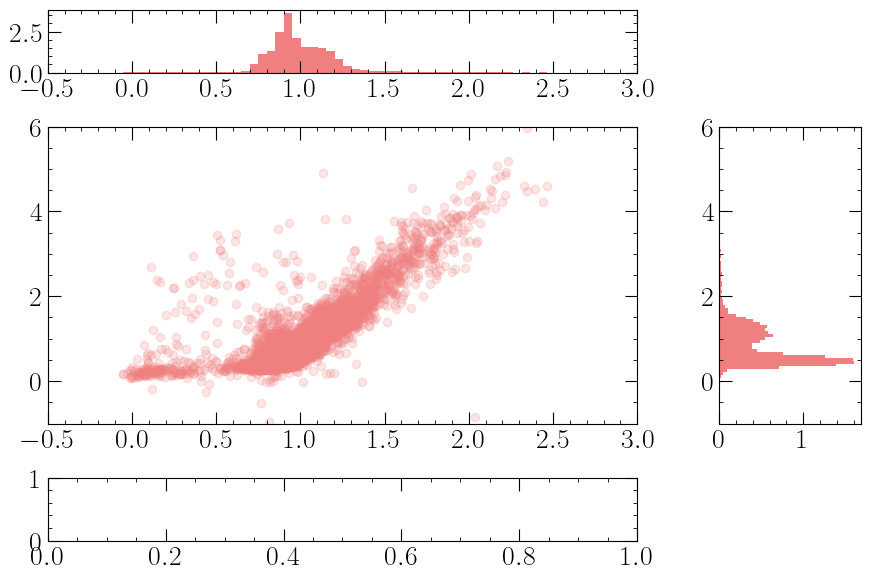

In [78]:
#try separating the top/side panels into curves of stellar types
fig, axs = plt.subplot_mosaic(mosaic#, width_ratios=[1, 1, 0.25], height_ratios=[0.25, 1, 1, 0.25]
        )
fig.set_size_inches(9,6)
fig.tight_layout()

axs['main plot'].scatter(jh, h36, alpha=0.2);
axs['main plot'].set_xlim(-0.5,3.0)
axs['main plot'].set_ylim(-1,6)

axs['JH panel'].set_xlim(-0.5,3.0)
axs['JH panel'].hist(jh, bins=50, density=True)

axs['H36 panel'].set_ylim(-1,6)
axs['H36 panel'].hist(h36, bins=100, density=True, orientation='horizontal');

In [79]:
x1 = np.linspace(-1.0, 1.14, 1000)
x2 = np.linspace(1.16, 2.5, 1000)
y1 = np.repeat(19.48, 1000)
y2 = 2 * x2 + 17.18

In [80]:
xs = np.concatenate((x1,x2), axis=0)
ys = np.concatenate((y1,y2), axis=0)

In [81]:
xg1 = np.linspace(-1.0, 1.2, 1000)
xg2 = np.linspace(1.2, 3, 1000)
yg1 = np.repeat(19.28, 1000)
yg2 = 2 * xg2 + 16.88

In [82]:
gxs = np.concatenate((xg1,xg2), axis=0)
gys = np.concatenate((yg1,yg2), axis=0)

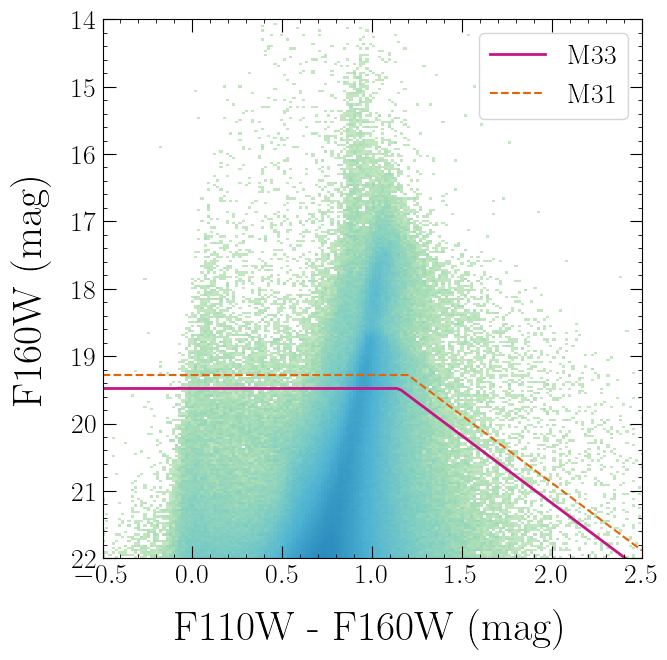

In [83]:
fig, ax = plt.subplots(1)

ax.set_aspect(3/8)


cmd = ax.hist2d(phatter.F110W_F160W.evaluate(), phatter.F160W_VEGA.evaluate(),
          bins=400,
          norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e5), 
          cmap='GnBu')
ax.plot(xs, ys, c='mediumvioletred', linestyle='-', linewidth=2, 
        label='M33' 
       )

ax.plot(gxs, gys, c='#E76404', linestyle='--', linewidth=1.5, 
        label='M31'
       )

ax.set_xlabel('F110W - F160W (mag)')
ax.set_ylabel('F160W (mag)')
ax.set_ylim(22,14)
ax.set_xlim(-0.5,2.5)

ax.legend(loc='best');

plt.savefig('./images/goldman_cut.png', bbox_inches='tight')

In [84]:
col_seq1 = ascii.read('./jh_h160.csv', names=['jh', 'h160'])

In [85]:
col_seq2 = ascii.read('./jh_h160_carbon.csv', names=['jh', 'h160'])

In [86]:
col_seq3 = ascii.read('./jh_j110.csv', names=['jh', 'j110'])

In [87]:
#J-H vs H-F160W fits

cfit_x1 = np.linspace(-0.1, 1.0, 100)
cfit_x2 = np.linspace(0.4, 1.4, 100)

cfit_xall = np.linspace(-0.1, 1.5, 100)
cdat_jh = np.concatenate([col_seq1['jh'], col_seq2['jh']])
cdat_h160 = np.concatenate([col_seq1['h160'], col_seq2['h160']])

order1 = np.argsort(col_seq1['jh'])
order2 = np.argsort(col_seq2['jh'])
order_all = np.argsort(cdat_jh)

cfit1 = spline(col_seq1['jh'][order1], col_seq1['h160'][order1], k=1)
cfit2 = spline(col_seq2['jh'][order2], col_seq2['h160'][order2], k=1)
cfit_all = spline(cdat_jh[order_all], cdat_h160[order_all], k=1)


cfit_y1 = cfit1(cfit_x1)
cfit_y2 = cfit2(cfit_x2)
cfit_yall = cfit_all(cfit_xall)

In [88]:
#J-H vs H-F110W fit

cfit3 = spline(col_seq3['jh'], col_seq3['j110'], k=1)
cfit_y3 = cfit4(cfit_xall)

NameError: name 'cfit4' is not defined

In [ ]:
b1, m1 = cfit1.get_coeffs()
b2, m2 = cfit2.get_coeffs()
b_all, m_all = cfit_all.get_coeffs()
b3, m3 = cfit3.get_coeffs()

In [ ]:
#uses meredith's transformation plots to convert from hst to 2mass

def solve_jh(f110, f160, m110, m160, b110, b160):
    #matrix of the form [h, j : f110 OR f160]
    coeff_mtrx = [[-m160, 1 + m160], 
                  [1 - m110, m110]
        ]
    ordinates = [float(f160) + b160, f110 + b110]
    soln = np.linalg.solve(coeff_mtrx, ordinates)
    j,h = soln[0], soln[1]
    return j,h

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(13,4)
fig.tight_layout(w_pad=8)

ax1.scatter(col_seq1['jh'], col_seq1['h160'])
ax1.scatter(col_seq2['jh'], col_seq2['h160'])

ax1.plot(cfit_x1, cfit_y1, color='firebrick')
ax1.plot(cfit_x2, cfit_y2, color='darkgreen')
ax1.plot(cfit_xall, cfit_yall, color='orange', linestyle='--')

ax1.set_xlabel('J-H')
ax1.set_ylabel('F160W-H')

ax1.set_ylim(-0.1, 0.6)


ax2.scatter(col_seq3['jh'], col_seq3['j110'], color='lightskyblue')
ax2.plot(cfit_xall, cfit_y3, color='purple')

ax2.set_xlabel('J-H')
ax2.set_ylabel('F110W_J')

ax2.set_ylim(-0.1, 0.7)

fig.text(0.5, 1.0, 'WebPlotDigitizer Extracted Data', ha='center', fontsize=30);

In [ ]:
###Define J and H for ph_data sources and add to dataframe
phatter['J_MAG'], phatter['H_MAG'] =  solve_jh(raw_f110, raw_f160, m3, m_all, b3, b_all)
phatter['J_H'] = phatter['J_MAG'] - phatter['H_MAG'] 

In [ ]:
#Color cuts to PHATTER sample following criteria from Goldman, et al 2022

phatter.select('IR_GST & ' 
               '(J_H >= 0.0) & (J_H <= 2.2) &'
               '(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18)))',
               name='COL_CUT')

In [ ]:
cut_110, cut_160 = phatter.F110W_VEGA.evaluate(selection='COL_CUT'), phatter.F160W_VEGA.evaluate(selection='COL_CUT')

In [ ]:
H_MAG, J_MAG = phatter.H_MAG.evaluate(selection='COL_CUT'), phatter.J_MAG.evaluate(selection='COL_CUT')
J_H = J_MAG - H_MAG

In [ ]:
###Convert J-H to H-3.6 using spline fit from LMC color locus

hh1, = np.where(J_H < x_intercept)
hh2, = np.where(J_H >= x_intercept)

H_36 = np.full_like(J_H, 0)

H_36[hh1] = fit1(J_H[hh1])
H_36[hh2] = fit2(J_H[hh2])


MAG_36 = H_MAG - H_36

###Convert 3.6 magnitude to flux density
FD_36 = spitzer_36mag_to_fd(MAG_36)

In [ ]:
filts = ['mag36', 'mag45', 'mag58', 'mag80', 'mag24']
new_cols = ['fd36', 'fd45', 'fd58', 'fd80', 'fd24']
funcs = [spitzer_36mag_to_fd, spitzer_45mag_to_fd, spitzer_58mag_to_fd, spitzer_80mag_to_fd, spitzer_24mag_to_fd]

for i in range(len(filts)):
    spitzer[new_cols[i]] = funcs[i](spitzer[filts[i]])


In [ ]:
spitzer[0]

In [ ]:
#index_colcut = phatter.INDEX.evaluate(selection='COL_CUT')

RA,DEC = phatter.RA.evaluate(selection='COL_CUT'), phatter.DEC.evaluate(selection='COL_CUT')

## Matching Process

In [ ]:
search_radius = 3 / 3600

In [ ]:
###Spitzer RA and DEC
ra_spitz, dec_spitz = np.array(spitzer['ra']), np.array(spitzer['dec'])

In [ ]:
bins_ra, bins_dec = ceil((np.max(ra_spitz) - np.min(ra_spitz)) / search_radius), ceil((np.max(dec_spitz) - np.min(dec_spitz)) / search_radius)
bins_ra, bins_dec

In [ ]:
ra_bins = np.linspace(np.min(ra_spitz), np.max(ra_spitz), bins_ra)
dec_bins = np.linspace(np.min(dec_spitz), np.max(dec_spitz), bins_dec)

In [ ]:
hist_spitz,hx,hy = np.histogram2d(ra_spitz, dec_spitz, bins=[ra_bins, dec_bins])
bin_nums_spitz = ri.get_indices(hist_spitz, ra_spitz, dec_spitz, x_bins=hx, y_bins=hy)

In [ ]:
hist_phatter,hxx,hyy = np.histogram2d(RA,DEC, bins=[hx,hy])
bin_nums_phatter = ri.get_indices(hist_phatter, RA,DEC, x_bins=hx, y_bins=hy)

In [ ]:
hist_gst,_,_ = np.histogram2d(ra_gst, dec_gst, bins=[hx,hy])
indgst =  ri.get_indices(hist_gst, ra_gst, dec_gst, x_bins=hx, y_bins=hy)

In [ ]:
spitz_i = 5000
s_bin_num= bin_nums_spitz[spitz_i]
p, = np.where(bin_nums_phatter == s_bin_num)
s_bin_num, p[:5]

In [ ]:
###Check that bin numbers are correctly aligned between the datasets
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)

bins = bins_dec

ax.set_aspect(m33_ar * 10/13)
#ax.set_ylim(30.4978, 30.499)
ax.set_xlabel('RA (deg)', fontsize=20)
ax.set_ylabel('DEC (deg)', fontsize=20)
ax.set_title('Spitzer bin: {}'.format(s_bin_num), fontsize=20)
ax.tick_params(axis='y', rotation=90)
ax.invert_xaxis()
ax.tick_params(axis='both', labelsize='large')

ax.scatter(spitzer['ra'][spitz_i], spitzer['dec'][spitz_i], 
           edgecolor='black', 
           facecolor='none', 
           marker='o',
           s=100,
           zorder=5,
           linewidths=2
          )
psf = patches.Circle((spitzer['ra'][spitz_i], spitzer['dec'][spitz_i]), 
                     radius=1/3600, 
                     edgecolor='gray', 
                     facecolor=(0,0,0,0),
                     linestyle='--',
                     linewidth=1)

search_rad = patches.Circle((spitzer['ra'][spitz_i], spitzer['dec'][spitz_i]), 
                     radius=search_radius, 
                     edgecolor='black', 
                     facecolor=(0,0,0,0),
                     linestyle=':',
                     linewidth=1)
ax.add_patch(psf)
ax.add_patch(search_rad)

bb = [s_bin_num, s_bin_num+1, s_bin_num-1, s_bin_num+ bins - 1, s_bin_num- bins + 1, s_bin_num+ bins, s_bin_num- bins, s_bin_num+ bins - 2, s_bin_num- bins + 2]
cc = ['yellowgreen', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']
#cc = ['xkcd:tangerine', 'greenyellow', 'greenyellow', 'turquoise', 'turquoise', 'coral', 'coral', 'coral', 'coral']

for i,bin in enumerate(bb):
    lox, = np.where(indgst == bb[i])
    ax.scatter(ra_gst[lox], dec_gst[lox],
               color=cc[i], s=25, alpha=0.3)
    
    final, = np.where(bin_nums_phatter == bb[i])
    ax.scatter(RA[final], DEC[final],
               color=cc[i], s=300)

    ax.text(np.max(ra_gst[lox]), np.mean(dec_gst[lox]),
                str(bin), fontsize=10)
    

    
plt.savefig('./images/bin_visuals.png', bbox_inches='tight')

In [ ]:
col = phatter.F110W_F160W.evaluate(selection='COL_CUT')

In [ ]:
ar_length = len(RA)
flux_fracs_spitzer = np.full(ar_length, -999.9)
flux_fracs_hst = np.full(ar_length, -999.9)
dists = np.full(ar_length, -999.9)
spitzer_match_index = np.full(ar_length, -999)
match_ids = np.full(ar_length, -99)
spitz_cols = np.full(ar_length, -999.9)
spitz_mags = np.full(ar_length, -999.9)
delta_ras = np.full(ar_length, 999.9)
delta_decs = np.full(ar_length, 999.9)
num_matches = np.full(ar_length, 0)

In [ ]:
ph_index = np.arange(0, ar_length, 1)

In [ ]:
biggest_ffh = []

In [ ]:
ar_length

In [ ]:
%%time
###Number of bins should match the number chosen for reverse indices above
bins = bins_dec

for i,source in enumerate(spitzer):
    ###Get bin of spitzer source
    s_bin_i= bin_nums_spitz[i]
    ###Get indices of PHATTER sources in the same or nearby bins
    loc, = np.where((bin_nums_phatter >= s_bin_i - bins) & (bin_nums_phatter <= s_bin_i + bins))
     
    ###Get the distance between each PHATTER source and the spitzer source
    delta_ra = (RA[loc] - spitzer['ra'][i])*np.cos(spitzer['dec'][i] * np.pi / 180)
    delta_dec = DEC[loc] - spitzer['dec'][i]
    
    dist = np.sqrt(delta_ra**2 + delta_dec**2)
                                                   
    
    ###Get indices of PHATTER sources where the above distance is 2" or less                                                                                                                                              
    matched, = np.where(dist <= search_radius)
    
    if len(matched) != 0:
        
        indices = ph_index[loc][matched]

        match_ids[indices] = spitzer['index'][i]

        ###Fraction of the 3.6 flux of every matched HST source over the 3.6 flux of spitzer source [i]                                                               
        flux_frac_s = FD_36[indices] / spitzer['fd36'][i]
        ###Fraction of the 3.6 flux of every matched HST source over the total of all matched HST sources
        tot_flux = np.sum(FD_36[indices])
        flux_frac_h = FD_36[indices] / tot_flux
        ###Adds all matching data to appropriate arrays                                                                                                                                            
        dists[indices] = dist[matched]     
        flux_fracs_spitzer[indices] = flux_frac_s
        flux_fracs_hst[indices] = flux_frac_h
        spitzer_match_index[indices] = i
        delta_ras[indices] = delta_ra[matched]
        delta_decs[indices] = delta_dec[matched]
        num_matches[indices] = len(matched)
        
        

        biggest_ffh.append(np.max(flux_frac_h))
        
        spitz_mag = spitzer[i]['mag36']
        spitz_col = spitzer[i]['mag36'] - spitzer[i]['mag45']
        spitz_mags[indices] = spitz_mag
        spitz_cols[indices] = spitz_col

In [ ]:
match, = np.where(match_ids != -99)

In [ ]:
len(col[match]), len(spitzer_match_index[match])

In [ ]:
f160w = phatter.F160W_VEGA.evaluate(selection='COL_CUT')

In [ ]:
df,ffs, ffh = dists[match] / (search_radius), flux_fracs_spitzer[match], flux_fracs_hst[match]

In [ ]:
c_matched = col[match]

In [ ]:
no_ones, = np.where(ffh != 1.0)
ones, = np.where(ffh == 1.0)

In [ ]:
hiffs, = np.where(ffs >=0.9)

In [ ]:
search_radius

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,6)

ss = np.argsort(FD_36[match][hiffs])#[::-1]
plot = ax.scatter(RA[match][hiffs][ss], np.absolute(delta_ras[match][hiffs][ss]), s=5, c=FD_36[match][hiffs][ss], cmap='viridis_r', vmax=4e-4)

ax.set_xlabel('RA')
ax.set_ylabel(r'$\Delta_{{{RA}}}$')

plt.colorbar(plot, ax=ax, label='Flux Density [3.6]');

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,8)
fig.tight_layout(w_pad=5)

cmap = cm.get_sub_cmap('hsv', 0.2, 1.0)

plot1 = stats.binned_statistic_2d(RA[match][hiffs], DEC[match][hiffs], 
                                 values=np.absolute(delta_ras[match][hiffs]), 
                                 statistic='mean', 
                                 bins=50 
                                 )
c1 = ax1.imshow(np.rot90(plot1[0]), cmap=cmap, vmax=0.0008)
ax1.invert_xaxis()

plot2 = stats.binned_statistic_2d(RA[match][hiffs], DEC[match][hiffs], 
                                 values=np.absolute(delta_decs[match][hiffs]), 
                                 statistic='mean', 
                                 bins=50
                                 )
c2 = ax2.imshow(np.rot90(plot2[0]), cmap=cmap, vmax=0.0008)
ax2.invert_xaxis()

ax1.set_aspect(m33_ar)
ax2.set_aspect(m33_ar)

plt.colorbar(c1, ax=ax1, label='delta_ra');
plt.colorbar(c2, ax=ax2, label='delta_dec');

In [ ]:
len(match), len(hiffs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,8)
fig.tight_layout(w_pad=5)

ss1 = np.argsort(np.absolute(delta_ras[match][hiffs]))#[::-1]
plot1 = ax1.scatter(RA[match][hiffs][ss1], DEC[match][hiffs][ss1], 
            c=np.absolute(delta_ras[match][hiffs])[ss1], cmap='Reds', 
            vmin=0, vmax=1.5e-3,
            s=5, 
           );
ax1.invert_xaxis()

ss2 = np.argsort(np.absolute(delta_decs[match][hiffs]))#[::-1]
plot2 = ax2.scatter(RA[match][hiffs][ss2], DEC[match][hiffs][ss2], 
            c=np.absolute(delta_decs[match][hiffs])[ss2], cmap='Blues', 
            vmin=0, vmax=1.5e-3,
            s=5, 
           );
ax2.invert_xaxis()

ax1.set_aspect(m33_ar)
ax2.set_aspect(m33_ar)
plt.colorbar(plot1, ax=ax1, label='delta_ra');
plt.colorbar(plot2, ax=ax2, label='delta_dec');

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15,15)
ss = np.argsort(ffs[hiffs])
#plot = ax.scatter(RA[match][hiffs][ss], DEC[match][hiffs][ss], s=1, c=ff[hiffs][ss], cmap='viridis', vmax=2);
plot = np.histogram2d(RA[match], DEC[match], bins=200, weights=ffs)
plot2 = np.histogram2d(RA[match], DEC[match], bins=200)
ax.imshow(np.rot90(plot[0]/plot2[0]), vmin=0, vmax=1, cmap='viridis');
#plt.colorbar(plot, ax=ax, label='ff');

In [ ]:
#number of plots - multiple of 4
n = 16
#Spitzer index to start at
k = 1000
###Get the first n spitzer object IDs for sources that have matches
first_n = np.unique(match_ids[match])[k:k+n]

In [ ]:
len(match_ids[match]), len(num_matches[match])

In [ ]:
match_ids[match]

In [ ]:
fig, axs = plt.subplots(int(n/4),4, figsize=(14,14*(n/16)))
fig.tight_layout(h_pad=1, w_pad=1)


for i,ax in enumerate(axs.ravel()[:n]):
 ob, = np.where(spitzer['index'] == first_n[i])
 ph, = np.where(match_ids[match] == first_n[i])
    
 matches_ffs = ffs[ph]
 colors_match = c_matched[ph]
 cmh = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
 ordered = np.argsort(matches_ffs)[::-1]
 max_ffs = matches_ffs[ordered][0].round(2)
 num = num_matches[match][ph]
    
 ax.set_aspect(1)   

 ax.errorbar(spitzer['ra'][ob], spitzer['dec'][ob], 
              xerr=search_radius, yerr=search_radius, 
            color='grey', 
            linewidth=2)
 psf_circle = patches.Circle((spitzer['ra'][ob], spitzer['dec'][ob]), 
                            1/3600,
                            edgecolor='dimgrey', facecolor='none', 
                            linestyle='--')
 ax.add_patch(psf_circle)

 wplot = ax.scatter(spitzer['ra'][ob], spitzer['dec'][ob], 
           s=1e3,
           c='lightgrey',
           label='Spitzer Source', 
           zorder=5)
 ss = np.argsort(matches_ffs)[::-1]
 cplot = ax.scatter(RA[match][ph][ss], 
                   DEC[match][ph][ss], 
                     s=matches_ffs[ss]*1e3, 
                     edgecolors='black', 
                     c=colors_match[ss], 
                     cmap=cmh, 
                     vmin=0.5, vmax=2., 
                     label='HST Matches', 
                     zorder=7) 
 
 x,y = spitzer['ra'][int(ob)], spitzer['dec'][int(ob)]
 dx, dy = 0.001, 0.001
 ax.set_xlim(x+dx, x-dx)
 ax.set_xticks([x-0.00075, x, x+0.00075])
 ax.set_xticklabels(["{:.3f}".format(x-dx),"{:.3f}".format(x),"{:.3f}".format(x+dx)], ha='center')
 ax.set_ylim(y-dy, y+dy)
 ax.set_yticks([y-0.00075, y, y+0.00075])
 ax.set_yticklabels(["{:.3f}".format(y-dy),"{:.3f}".format(y),"{:.3f}".format(y+dy)], va='center')
 ax.tick_params(axis='x',labelsize=15)
 ax.tick_params(axis='y',labelsize=15, rotation=90)


 maxf_text = ax.text(x-0.0001, y+0.0008, 'Max FF: ' + str(max_ffs), 
         fontsize=13, fontweight='bold', 
         color='darkturquoise', 
         bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen', lw=1))
 
 plotnum_text = ax.text(x+0.0009, y+0.0008, str(i+1),
                       fontsize=15, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen'))
# end of loop

hst_cax = fig.add_axes([1.0, 0.0, 0.05, 1])
hst_cbar = fig.colorbar(cplot, cax=hst_cax)
hst_cbar.ax.tick_params(which='both', size=0)
hst_cbar.set_label('F110W - F160W')

fig.text(0.5, -0.05, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.025, 0.5, 'DEC (deg)', rotation='vertical', verticalalignment='center', fontsize=30);

plt.savefig('./images/cutout_plots.png', bbox_inches='tight')

## Random Matches

In [ ]:
shifts = np.array([-36, -24, -12, 12, 24, 36])
distances_shift = []
flux_fracs_shift_spitzer = []
flux_fracs_shift_hst = []
ras_shift = []
decs_shift = []
uw_ind = []
cols_shift = []

In [ ]:
for j,shift in enumerate(shifts):
  ra_shift = spitzer['ra'] + (shift/3600)
  d = []
  f = []
  f2 = []
  ra = []
  dec = []
  uind = []
  color=[]

  for i,source in enumerate(spitzer):                
    dd = np.sqrt( ((RA - ra_shift[i])*np.cos(spitzer['dec'][i] * np.pi / 180))**2 + 
               (DEC - spitzer['dec'][i])**2)
    fmatched, = np.where(dd <= 2/3600)
  
    if len(fmatched) != 0:
      fsm = FD_36[fmatched] / spitzer['fd36'][i]
      ftot = np.sum(FD_36[fmatched])
      fsm2 = FD_36[fmatched] / ftot

      d.append(dd[fmatched])
      f.append(fsm)
      f2.append(fsm2)
      ra.append(RA[fmatched])
      dec.append(DEC[fmatched])
      uind.append([i]*len(fmatched))
      color.append(col[fmatched])
        

  dds = [x for group in d for x in group]
  ffracs = [x for group in f for x in group]
  ffracs2 = [x for group in f2 for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift_spitzer.append(ffracs)
  flux_fracs_shift_hst.append(ffracs2)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [ ]:
for j,shift in enumerate(shifts):
  dec_shift = spitzer['dec'] + (shift/3600)
  d = []
  f = []
  f2 = []
  ra = []
  dec = []
  uind = []
  color = []

  for i,source in enumerate(spitzer):                
    dd = np.sqrt( ((RA - spitzer['ra'][i])*np.cos(dec_shift[i] * np.pi / 180))**2 + 
               (DEC - dec_shift[i])**2)
    fmatched, = np.where(dd <= 2/3600)
  
    if len(fmatched) != 0:
      fsm = FD_36[fmatched] / spitzer['fd36'][i]
      ftot = np.sum(FD_36[fmatched])
      fsm2 = FD_36[fmatched] / ftot
    
      d.append(dd[fmatched])
      f.append(fsm)
      f2.append(fsm2)
      ra.append(RA[fmatched])
      dec.append(DEC[fmatched])
      uind.append([i]*len(fmatched))
      color.append(col[fmatched])
        

  dds = [x for group in d for x in group]
  ffracs = [x for group in f for x in group]
  ffracs2 = [x for group in f2 for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift_spitzer.append(ffracs)
  flux_fracs_shift_hst.append(ffracs2)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [ ]:
d_shift = np.array([l for group in distances_shift for l in group])
f_shift_spitzer = np.array([k for group in flux_fracs_shift_spitzer for k in group])
f_shift_hst = np.array([m for group in flux_fracs_shift_hst for m in group])
c_shift = np.array([j for group in cols_shift for j in group])

In [ ]:
false_ra = np.array([x for group in ras_shift for x in group])
false_dec = np.array([x for group in decs_shift for x in group])
false_uind = np.array([x for group in uw_ind for x in group])

## Catalog

In [ ]:
rand_no_ones, = np.where(f_shift_hst != 1.0)

In [ ]:
obs_df_data = {'dist_frac':df[no_ones],
               'flux_frac_spitzer':ffs[no_ones],
               'flux_frac_hst':ffh[no_ones],
               '110_160_col':col[match][no_ones]
              }

rand_df_data = {'dist_frac':d_shift[rand_no_ones],
               'flux_frac_spitzer':f_shift_spitzer[rand_no_ones],
               'flux_frac_hst':f_shift_hst[rand_no_ones],
               '110_160_col':c_shift[rand_no_ones]
              } 

In [ ]:
rand = aspy.table.Table(rand_df_data)
rand.write('./random.csv', names=['dist_frac', 'flux_frac_spitzer', 'flux_frac_hst', 'f110_f160'], overwrite=True)

In [ ]:
obs = aspy.table.Table(obs_df_data)
obs.write('./observed.csv', names=['dist_frac', 'flux_frac_spitzer', 'flux_frac_hst', 'f110_f160'], overwrite=True)

In [ ]:
kde_probs = pd.read_csv('./kde_probs.csv')

In [ ]:
kde_probs.head()

In [ ]:
f275 = phatter.F275W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f336 = phatter.F336W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f475 = phatter.F475W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f814 = phatter.F814W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f110 = phatter.F110W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f160 = phatter.F160W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
full_index = phatter.full_index.evaluate(selection='COL_CUT')[match][no_ones]

In [ ]:
columns = [RA[match][no_ones], DEC[match][no_ones], delta_ras[match][no_ones], delta_decs[match][no_ones], 
           f275, f336, f475, f814, f110, f160,
           MAG_36[match][no_ones],
           spitzer_match_index[match][no_ones],
           full_index,
           spitzer['mag36'][spitzer_match_index[match][no_ones]], 
           spitzer['mag45'][spitzer_match_index[match][no_ones]], 
           spitzer['mag58'][spitzer_match_index[match][no_ones]], 
           spitzer['mag80'][spitzer_match_index[match][no_ones]], 
           spitzer['mag24'][spitzer_match_index[match][no_ones]],
           df[no_ones], ffs[no_ones], ffh[no_ones],
           kde_probs['good_prob'], kde_probs['rand_prob'],
           num_matches[match][no_ones]
          ]

In [ ]:
names = ['ra', 'dec', 'delta_ra', 'delta_dec', 
         'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA', 'F110W_VEGA', 'F160W_VEGA',
         'estimated_36mag',
         'spitzer_index', 
         'PHATTER_index', 
         'mag36', 'mag45', 'mag58', 'mag80', 'mag24', 
         'frac_dist', 'frac_flux_s', 'frac_flux_h',
         'good_prob', 'rand_prob',
         'num_matches'
        ]

In [ ]:
#catalog = pd.DataFrame(data=columns, columns=names)

In [ ]:
###Create table with index of the PHATTER data and the objid of the wise source it matched to

#objid_key = Table([phatter.INDEX.evaluate(), match_ids], names=['phatter_index', 'unwise_objid'])

In [ ]:
#m, = np.where(objid_key['unwise_objid'] != '****************')

In [ ]:
#objid_key[m].write('objid_key.csv')


## SED Fitting

In [ ]:
def rj_curve(T_eff, lam):
    F_lambda = (2 * C.c * C.k_B * T_eff) / (lam**4)
    F_nu = F_lambda.to(u.W / u.m**3).value * ((lam.to(u.um).value)**2 / (C.c.to(u.um / u.s).value))
    return F_nu

lambdas = np.linspace(1e-3, 30, 1000)*u.um

filters = [3.6, 4.5, 5.8, 8.0, 24.0]

seds = np.array([spitzer['fd36'], spitzer['fd45'], spitzer['fd58'], spitzer['fd80'], spitzer['fd24']]).T

fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)

i = 100
temps = np.arange(2000, 12000, 2000)


ax.scatter(filters, seds[i])

for temp in temps:
    rj_tail = rj_curve(temp*u.K, lambdas)
    ax.plot(lambdas, rj_tail, label=str(temp) + 'K')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\lambda$ [$\mu m$]')#'  $[\mu m]$')
ax.set_ylabel(r'$F_\nu$ [Jy]')

ax.legend(loc=1, fontsize=15);